# Histograms of track parameters grouped by categories

In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from common_defs import nyr, aliases
import mypaths
from plot_utils import iletters

from octant.core import TrackRun, OctantTrack
from octant.misc import SUBSETS
import octant
octant.__version__

'0.0.10'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
subset_aliases = {'all': 'All', **aliases}

In [4]:
plt.style.use('paperfig.mplstyle')

In [5]:
dset_names = (
    ('era5_run000', 'ERA5, CTRL'),
)

In [6]:
track_runs = dict()
for (dset_name, _) in dset_names:
    TR = TrackRun()
    TR.data = OctantTrack.from_mux_df(pd.read_parquet(mypaths.procdir / f'{dset_name}_2008_2017.parquet', engine='pyarrow'))
    TR.is_categorised = True
    track_runs[dset_name] = TR

In [7]:
subsets = ['all'] + SUBSETS

In [8]:
vrbl_dict = dict(area=dict(range=(0, 400), bins=8, title='Approx. diameter [km]'),
                 average_speed=dict(range=(0, 100), bins=10, title='Propagation velocity [$km$ $h^{-1}$]'),
                 gen_lys_dist_km=dict(range=(0, 2000), bins=10, title='Genesis-lysis distance [km]'),
                 lifetime_h=dict(range=(0, 72), bins=12, title='Life time [h]'),
                 total_dist_km=dict(range=(0, 3200), bins=8, title='Total distance [km]'),
                 max_vort=dict(range=(0, 10), bins=10, title='Maximum vorticity [$10^{-4}$ $s^{-1}$]'))

In [9]:
track_summary = {}
for subset in subsets:
    track_summary[subset] = pd.DataFrame([[getattr(ct, vrbl_name) if vrbl_name != 'area' else 2*(getattr(ct, vrbl_name).mean()/np.pi)**0.5
                                           for vrbl_name in vrbl_dict.keys()]
                                          for i, ct in TR[subset].groupby('track_idx')],
                                          columns=vrbl_dict.keys())

In [10]:
for subset in subsets:
    track_summary[subset].max_vort *= 1e4

In [11]:
plt_kw_list = [
    dict(color='C7', alpha=0.2),
    dict(color='C7', alpha=0.5),
    dict(color='#8DBAD7', linewidth=2/3, edgecolor='#000000'),
    dict(color='C0', linewidth=2/3, edgecolor='#000000')
]

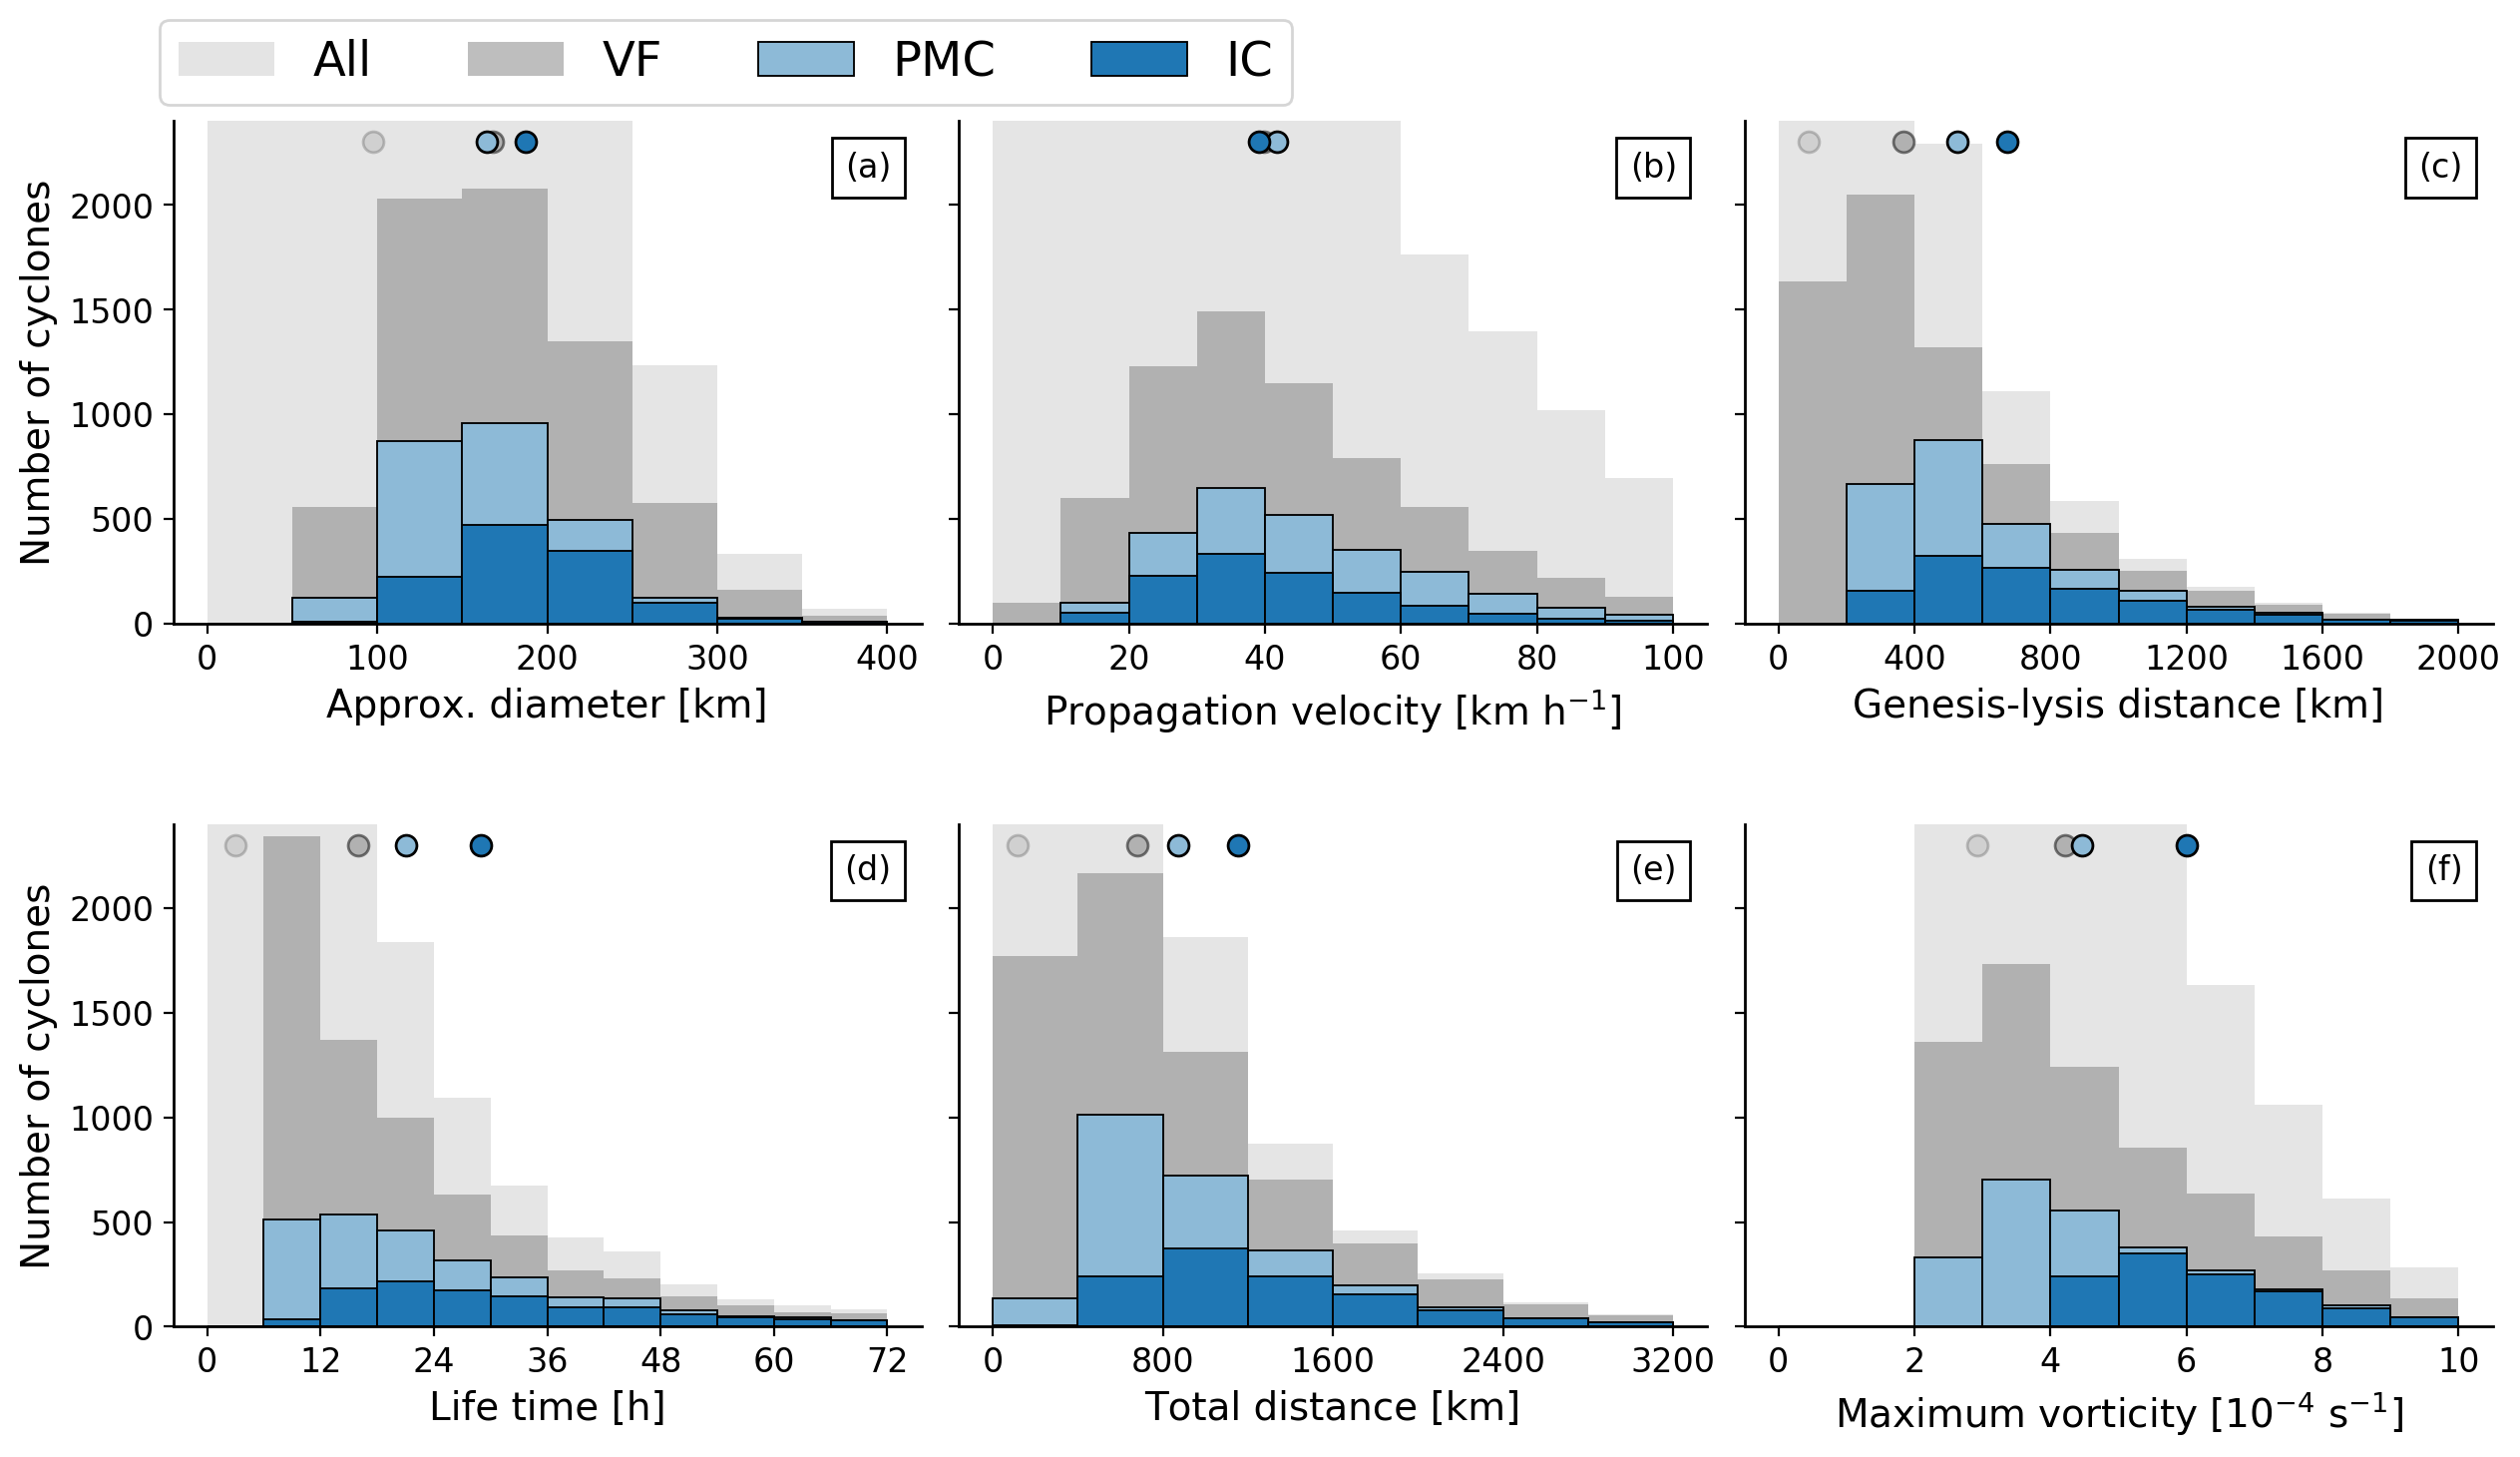

In [14]:
# import string
# iletters = iter(string.ascii_lowercase)

ymax = 2400

ncols = 3
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, gridspec_kw=dict(hspace=0.4, wspace=0.05))

for ax, (vrbl_name, hist_kw) in zip(axs.flat, vrbl_dict.items()):
    ttl = hist_kw.pop('title')
    for subset, plt_kw in zip(subsets, plt_kw_list):
        track_summary[subset][vrbl_name].hist(ax=ax, label=subset_aliases[subset], **plt_kw, **hist_kw)
        med_val = np.percentile(track_summary[subset][vrbl_name], 50)
        ax.plot(med_val, ymax-100, alpha=plt_kw.get('alpha', 1), mfc=plt_kw['color'], marker='o', ms=7.5, mec='k', zorder=100)
    ax.set_xticks(np.linspace(*hist_kw['range'], hist_kw['bins']//2+1))
    ax.grid(False)
    ax.set_ylim(0, ymax)
    ax.add_artist(AnchoredText(f'({next(iletters)})', loc=1, frameon=True))
    ax.set_xlabel(ttl)
    
    for spine in ax.spines.values():
        if spine.spine_type in ['top', 'right']:
            spine.set_linewidth(0)
        else:
            spine.set_linewidth(1)
    
for axrow in axs:
    axrow[0].set_ylabel('Number of cyclones')
axs.flatten()[0].legend(fontsize='x-large', ncol=4, loc=2, bbox_to_anchor=(-0.05, 1.25))

In [15]:
fig.savefig(mypaths.plotdir / f'pmctrack_cats_stats_{dset_name}')